In [82]:
%matplotlib notebook

%matplotlib ipympl

import boost_histogram as bh
import mplhep

import numpy as np

import pandas as pd

import h5py
import matplotlib.pyplot as plt

from ipywidgets import *

from geohelper import geohelper

In [2]:
from sklearn.neighbors import NearestNeighbors

In [3]:
class neighbor_finder:
    """Find out nearest neighbors
    """
    def __init__(self):
        self.points = np.array([])
        self.finder = NearestNeighbors(n_neighbors=1, algorithm='kd_tree')
    def load_points(self, points):
        self.points = points
    def find_k_neighbors(self, points, k):
        if k > 1:
            self.finder = NearestNeighbors(n_neighbors=k, algorithm='kd_tree')
        elif k <=0:
            raise NotImplementedError("k must be non-negative")
        self.finder.fit(self.points)
        distances, indices = self.finder.kneighbors(points)
        return distances, indices

In [4]:
### all Bern module data has been uploaded to NERSC - a NERSC account is not needed to access
### see this link for click-downloadable files: https://portal.nersc.gov/project/dune/data/Module1/TPC12/dataRuns/packetData/
file2306='packet_2022_02_10_22_58_34_CET.h5'
ftimestamp=file2306.split("/")[-1].split('2022_02_10_')[-1].split("_CET")[0]

In [5]:
f=h5py.File(file2306,'r')
io_group_mask=f['packets']['io_group']==1 # selects packets from a specific TPC
packets=f['packets'][io_group_mask]
sync_mask=((packets['packet_type']==6)&(packets['trigger_type']==83)) # selects SYNC packets that are externally generated
print(sync_mask.shape)
sync_idcs=np.argwhere(sync_mask).flatten()
message_groups=np.split(packets, sync_idcs) # partition the packet dataset by sync packet index
print(len(message_groups),' packet groups partitioned by sync packets')

(48479011,)
1201  packet groups partitioned by sync packets


In [79]:
picked_points = np.array([])

def generate_lines(points, lims):
    lims = lims.astype(np.float64)
    points = points.transpose()
    # normalize
    opoints = points.copy()
    points = (points - np.vstack([lims[:,0], lims[:,0]]).transpose()) / (np.vstack([lims[:,1], lims[:,1]]) - np.vstack([lims[:,0], lims[:,0]])).transpose()
    dxyz = np.array([points[i,0] - points[i,1] for i in range(3)])
    output = lims.copy()
    i = np.argmax(np.abs(dxyz))
    if dxyz[i]:
        for j in range(3):
            for k in range(2):
                output[j,k] = points[j,0] + dxyz[j]/dxyz[i] * (k - points[i,0])
    else:
        raise ValueEror
    output = output * (np.vstack([lims[:,1], lims[:,1]]) - np.vstack([lims[:,0], lims[:,0]])).transpose() + np.vstack([lims[:,0], lims[:,0]]).transpose()
    output = output.transpose()
    return output

def interactive_plot_adc(sync_group, counter, threshold):
    """plot ADC sum given (xpos, ypos).
    sync_group: integer, packets within the same SYNC
    counter: integer, the bin to plot, containing larger number of packets than threshold
    threshold: minimum of threshold within a time duration
    """

    
    plt.close('all')

    helper = geohelper()

    mg = message_groups[sync_group]
    data_mask=((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp 
    data_packets=mg[data_mask]
    print(len(data_packets),' data packets between syncs')

    # histogram the timestamp packet field
    # roughly 200 microseconds binning assuming ticks up to value 1e7 in datastream between syncs
    counts, xbins = np.histogram(data_packets['timestamp'], bins=500)
    bin_width=xbins[1]-xbins[0]

    physics_bins=[] # save to list bin index for bins exceeding threshold
    for i in range(len(counts)):
        if counts[i]>threshold: physics_bins.append(i)

    print(len(physics_bins),' candidate events')

    if len(physics_bins)==1: return # due to correlated-sync noise, we will always have significant pickup near 0 timestamp


    event_mask = (data_packets['timestamp']>=physics_bins[counter]*bin_width)&(data_packets['timestamp']<physics_bins[counter]*bin_width+bin_width) # filter packets on histgrammed bin of interest
    hits = data_packets[event_mask]
    io_channel = hits['io_channel']
    tile_id = np.array([helper.io_channel_to_tile(ioc) for ioc in io_channel])
    chip_id = hits['chip_id']
    channel_id = hits['channel_id']
    timestamp = hits['timestamp']/1e4 # ms
    dataword = hits['dataword'] # ADC value
    # correlate hardware ID to geometry information to find (x,y) position of hits
    xys = np.fromiter((helper.find_xy(tile, chip, channel) for tile, chip, channel in zip(tile_id, chip_id, channel_id)),
                      dtype=np.dtype((np.float64, 2)))
    x = xys[:,0]
    y = xys[:,1]

    print(len(dataword),' hits in event')

    
    tmin0 = physics_bins[counter]*bin_width / 1E4  #ms
    tmax0 = (physics_bins[counter]*bin_width+bin_width) / 1E4  # ms


    ############
    
    output = widgets.Output()

    figsizeunit = 5
    
    ############
    plt.ioff()
    fig3d = plt.figure('event display & ADC sum', figsize=(2*figsizeunit, figsizeunit))
    ax3d = fig3d.add_subplot(121, projection='3d')
    axslice = fig3d.add_subplot(122)

    figproj = plt.figure('projection of event display', figsize=(2*figsizeunit, 2*figsizeunit))
    axty = figproj.add_subplot(223)
    axxy = figproj.add_subplot(224)
    axtx = figproj.add_subplot(221)
    axproj3d = figproj.add_subplot(222, projection='3d')
    
    fig2 = plt.figure('ADC sum of single channels', figsize=(2*figsizeunit, figsizeunit))
    axadc = fig2.add_subplot(121)
    axadcshift = fig2.add_subplot(122)

    fig3 = plt.figure('ADC sum of single channels, by id', figsize=(2*figsizeunit, figsizeunit))
    axchanneladc = fig3.add_subplot(121)
    axchanneladcshift = fig3.add_subplot(122)


    # from mpl_toolkits.mplot3d import proj3d
    # https://github.com/matplotlib/matplotlib/issues/11309
    # https://stackoverflow.com/questions/50283031/matplotlib-ax-format-coord-in-3d-trisurf-plot-return-x-y-z-instead-of-az
    # def getxyz(ax, x,y):
    #         coord = ax._location_coords(x, y, None)
    #         return coord

    # https://www.stevejpurves.com/blog/debugging-ipywidgets-in-a-jupyter-notebook
    # def on_pick_point(event):
    #     with output if output else nullcontext():
    #         # print(event)
    #         # s = getxyz(ax3d, event.xdata, event.ydata)
    #         xyzstrs = s.split(',')
    #         # print(xyzstrs)
    #         # https://stackoverflow.com/questions/19627609/python-convert-unicode-minus-sign-to-float
    #         xyz = [ np.float64(v.split('=')[-1].replace(u'\u2212', '-').replace('$', '')) for v in xyzstrs]
    #         # print(xyz)
    #         global picked_points
    #         if len(picked_points) > 1:
    #             picked_points = picked_points[-2:]
    #         elif len(picked_points) == 0:
    #             picked_points = np.array(xyz).reshape(1, 3)
    #         else:
    #             picked_points = np.vstack([picked_points, xyz])
    #         print("Selected:", picked_points)
    def on_pick_point(event):
        with output if output else nullcontext():
            x, y = event.xdata, event.ydata
            global picked_points
            if len(picked_points) == 0:
                picked_points = np.array([x, y]).reshape(1, 2)
            elif len(picked_points) != 4:
                picked_points = np.vstack([picked_points, [x, y]])
            else:
                print("Not adding anymore")
            if len(picked_points) == 4:
                picked_points = np.array(
                    [[picked_points[2,0], picked_points[0,0], picked_points[0,1]], 
                    [picked_points[3,0], picked_points[1,0], picked_points[1,1]]]
                )
                print("Set boundaries", picked_points)
    
    def plot_3d():
        global scat3d
        ax3d.clear()
        scat3d = ax3d.scatter(timestamp, x, y, s=1, picker=True, pickradius=5)
        ax3d.set_xlabel("Timestamp [0.1E4 us]")
        ax3d.set_ylabel("x []", labelpad=10)
        ax3d.set_zlabel("y []")
        plt.tight_layout()
        fig3d.canvas.draw_idle()
        
        # fig3d.canvas.mpl_connect('pick_event', on_pick_point)
        # fig3d.canvas.mpl_connect('button_press_event', on_pick_point)
        fig3d.canvas.flush_events()

    def update_range(updatebutton):
        # plot_adc_slice()
        plot_proj()

    def plot_adc_slice():
        axslice.clear()
        x0, x1 = ax3d.get_xlim()
        y0, y1 = ax3d.get_ylim()
        z0, z1 = ax3d.get_zlim()
        # print("x range:", y0, y1, "[]")
        # print("y range:", z0, z1, "[]")
        # print("t range:", x0, x1, "[]")
        t0 = x0
        t1 = x1

        adcmask = (timestamp > x0) & (timestamp < x1) & (x > y0) & (x < y1) & (y > z0) & (y < z1)

        nbins = 50
        counts, bins = np.histogram(timestamp[adcmask], bins=nbins, range=(t0, t1), weights=dataword[adcmask])
        axslice.stairs(counts, bins)
        
        axslice.set_ylabel("ADC sum per {} [0.1E4 us]".format((t1-t0)/nbins))
        axslice.set_xlabel("Timestamp [0.1E4 us]")
        
        fig3d.canvas.draw_idle()
        fig3d.canvas.flush_events()

    def plot_proj():
        t0, t1 = ax3d.get_xlim()
        x0, x1 = ax3d.get_ylim()
        y0, y1 = ax3d.get_zlim()
        axtx.clear()
        axty.clear()
        axxy.clear()
        axproj3d.clear()

        axtx.set_xlabel('timestamp [0.1E4 us]')
        axtx.set_ylabel('x []')
        axty.set_xlabel('timestamp [0.1E4 us]')
        axty.set_ylabel('y []')
        axxy.set_xlabel('x []')
        axxy.set_ylabel('y []')

        adcmask = (timestamp > t0) & (timestamp < t1) & (x > x0) & (x < x1) & (y > y0) & (y < y1)
        
        # axtx.scatter(timestamp[adcmask], x[adcmask], marker='o', c=dataword[adcmask])
        # axty.scatter(timestamp[adcmask], y[adcmask], marker='o', c=dataword[adcmask])
        # axxy.scatter(x[adcmask], y[adcmask], marker='o', c=dataword[adcmask])
        axtx.scatter(timestamp[adcmask], x[adcmask], marker='o')
        axty.scatter(timestamp[adcmask], y[adcmask], marker='o')
        axxy.scatter(x[adcmask], y[adcmask], marker='o')
        axproj3d.scatter(timestamp[adcmask], x[adcmask], y[adcmask], s=1, marker='o')

        axtx.set_xlim(t0, t1)
        axtx.set_ylim(x0, x1)
        axty.set_xlim(t0, t1)
        axty.set_ylim(y0, y1)
        axxy.set_xlim(x0, x1)
        axxy.set_ylim(y0, y1)
        axproj3d.set_xlim(t0, t1)
        axproj3d.set_ylim(x0, x1)
        axproj3d.set_zlim(y0, y1)

        # global picked_points
        if len(picked_points):
            # zs = np.linspace(picked_points[:,2])
            points = generate_lines(picked_points, np.array([[t0, t1], [x0, x1], [y0, y1]]))
            with output:
                print(points)
            axtx.plot(points[:,0], points[:,1], color='r')
            axty.plot(points[:,0], points[:,2], color='r')
            axxy.plot(points[:,1], points[:,2], color='r')
            axproj3d.plot(points[:,0], points[:,1], points[:,2], color='r')
        
        figproj.canvas.draw_idle()
        figproj.canvas.mpl_connect('button_press_event', on_pick_point)
        figproj.canvas.flush_events()

 
    k_w = widgets.IntSlider(value=1, min=1, max=10, description='k nearest points', layout={"width": '500px'})
    trange_w = widgets.FloatRangeSlider(value=(tmin0, tmax0), min=tmin0, max=tmax0, description="time stamp min", layout={"width": '500px'})
    points_w = widgets.TagsInput(
        value=[],
        allow_duplicates = False
    )
    def plot_adc(trange, k=1, points=[]):
        axadc.clear()
        axadcshift.clear()

        ### axadcshift
        tlines = None
        nearestchannel = None
        if picked_points.shape == (2, 3):
            t0, t1 = ax3d.get_xlim()
            x0, x1 = ax3d.get_ylim()
            y0, y1 = ax3d.get_zlim()
            boundaries = generate_lines(picked_points, np.array([[t0, t1], [x0, x1], [y0, y1]]))
            npts = 5000
            xylines = np.array([np.linspace(boundaries[0,i], boundaries[1,i], npts) for i in range(1, 3)])
            tlines = np.linspace(boundaries[0,0], boundaries[1,0], npts)
            nearestchannel = neighbor_finder()
            nearestchannel.load_points(xylines.transpose())

        
        ### axadc
        tmin = trange[0]
        tmax = trange[1]

        # adcmask = (timestamp > t0) & (timestamp < t1) & dataword > 0
        
        adcmask = (timestamp > tmin) & (timestamp < tmax) & (dataword > 0)
        xtemp = x[adcmask]
        ytemp = y[adcmask]
        xyvalid = np.stack([xtemp, ytemp]).transpose()
        nearestxy = neighbor_finder()
        
        xyvalid = np.unique(xyvalid, axis=0)
        
        nearestxy.load_points(xyvalid)
    
        nbins = 50
    
        counts = []
        labels = []

        for p in points:
            try:
                (i, j) = p.split(',')
                i = float(i.strip())
                j = float(j.strip())
                # print(i, j)
                distances, indices = nearestxy.find_k_neighbors([[i, j]], k=k)
                for idx in indices[0]:
                    xvalid, yvalid = xyvalid[idx]
                    tileid, chipid, channelid = helper.find_ids(xvalid, yvalid)
                    labels.append("({:.1f},{:.1f})->({:.1f},{:.1f})->{}:{}:{}".format(i, j, xvalid, yvalid, tileid, chipid, channelid))
                    idmask = (tile_id == tileid) & (chip_id == chipid) & (channel_id == channelid)

                    ### axadc
                    
                    # h, bins = np.histogram(timestamp[idmask], bins=nbins, range=(tmin, tmax), weights=dataword[idmask])
                    # counts.append(h)
                    # axadc.stairs(h, bins, label=labels[-1])
                    # adcmask = idmask & (timestamp > tmin) & (timestamp < tmax)
                    # adcmask = idmask
                    # axadc.scatter(timestamp[adcmask], dataword[adcmask], c='r', marker='o')
                    
                    hist = bh.Histogram(bh.axis.Regular(nbins, tmin, tmax))
                    hist.fill(timestamp[idmask], weight=dataword[idmask])
                    h = hist.view()
                    mplhep.histplot(hist, ax=axadc, label=labels[-1])
                    adcmask = idmask & (timestamp > tmin) & (timestamp < tmax)
                    axadc.scatter(timestamp[adcmask], dataword[adcmask], c='r', marker='o')

                    ### axadcshift
                    # with output:
                        # print("tlines1", tlines)
                    if isinstance(tlines, np.ndarray):
                        # with output:
                        distances, indices = nearestchannel.find_k_neighbors([[xvalid, yvalid]], k=1)
                        
                            # print("tlines", tlines)
                        shift = tlines[indices[0][0]]

                        # hshift, binsshift = np.histogram(timestamp[idmask]-shift, bins=nbins, range=(tmin-shift, tmax-shift), weights=dataword[idmask])
                        # axadcshift.stairs(hshift, binsshift, label=labels[-1])
                        histshift = bh.Histogram(bh.axis.Regular(nbins, tmin-shift, tmax-shift))
                        histshift.fill(timestamp[idmask]-shift, weight=dataword[idmask])
                        mplhep.histplot(histshift, ax=axadcshift, label=labels[-1])
                        axadcshift.scatter(timestamp[adcmask]-shift, dataword[adcmask], c='r', marker='o')
                        
            except ValueError:
                continue

        axadc.set_ylabel("ADC sum per {} [0.1E4 us]".format(bin_width/nbins))
        axadc.set_xlabel("Timestamp [0.1E4 us]")
        if labels:
            axadc.legend()
        fig2.canvas.draw_idle()
        fig2.canvas.flush_events()

    channels_w = widgets.TagsInput(
        value=[],
        allow_duplicates = False
    )
    
    def plot_channel_adc(trange, channels=[]):
        axchanneladc.clear()
        axchanneladcshift.clear()

        ### axadcshift
        tlines = None
        nearestchannel = None
        if picked_points.shape == (2, 3):
            t0, t1 = ax3d.get_xlim()
            x0, x1 = ax3d.get_ylim()
            y0, y1 = ax3d.get_zlim()
            boundaries = generate_lines(picked_points, np.array([[t0, t1], [x0, x1], [y0, y1]]))
            npts = 5000
            xylines = np.array([np.linspace(boundaries[0,i], boundaries[1,i], npts) for i in range(1, 3)])
            tlines = np.linspace(boundaries[0,0], boundaries[1,0], npts)
            nearestchannel = neighbor_finder()
            nearestchannel.load_points(xylines.transpose())

        ### axchanneladc
        tmin = trange[0]
        tmax = trange[1]
        
        adcmask = (timestamp > tmin) & (timestamp < tmax) & (dataword > 0)

        nbins = 50
    
        counts = []
        labels = []

        for c in channels:
            tile, chip, channel = [ int(i.strip()) for i in c.split(',')]
            xpos, ypos = helper.find_xy(tile, chip, channel)
            labels.append("({}:{}:{}".format(tile, chip, channel))
            idmask = (tile_id == tile) & (chip_id == chip) & (channel_id == channel)

            ### axchanneladc
            # h, bins = np.histogram(timestamp[idmask], bins=nbins, range=(tmin, tmax), weights=dataword[idmask])
            # counts.append(h)
            # axchanneladc.stairs(h, bins, label=labels[-1])
            hist = bh.Histogram(bh.axis.Regular(nbins, tmin, tmax))
            hist.fill(timestamp[idmask], weight=dataword[idmask])
            h = hist.view()
            # bins = h
            mplhep.histplot(hist, ax=axchanneladc, label=labels[-1])
            # axchanneladc.hist(timestamp[idmask], bins=nbins, range=(tmin, tmax), weights=dataword[idmask], label=labels[-1])
            adcmask = idmask & (timestamp > tmin) & (timestamp < tmax)
                    # adcmask = idmask
            axchanneladc.scatter(timestamp[adcmask], dataword[adcmask], c='r', marker='o')
            '''
            with output:
                print("tmin, tmax", tmin, tmax)
                print("timestamp hist", timestamp[idmask])
                print("adc hist", dataword[adcmask])
                print("timestamp scatter", timestamp[idmask])
                print("adc scatter", dataword[adcmask])
                print("stat", h)
                '''
            if isinstance(tlines, np.ndarray):
                # with output:
                distances, indices = nearestchannel.find_k_neighbors([[xpos, ypos]], k=1)
                        
                shift = tlines[indices[0][0]]

                histshift = bh.Histogram(bh.axis.Regular(nbins, tmin-shift, tmax-shift))
                histshift.fill(timestamp[idmask]-shift, weight=dataword[idmask])
                # hshift, binsshift = np.histogram(timestamp[idmask]-shift, bins=nbins, range=(tmin-shift, tmax-shift), weights=dataword[idmask])
                # axchanneladcshift.stairs(hshift, binsshift, label=labels[-1])
                mplhep.histplot(histshift, ax=axchanneladcshift, label=labels[-1])
                axchanneladcshift.scatter(timestamp[adcmask]-shift, dataword[adcmask], c='r', marker='o')
                
        axchanneladc.set_ylabel("ADC sum per {} [0.1E4 us]".format(bin_width/nbins))
        axchanneladc.set_xlabel("Timestamp [0.1E4 us]")
        if labels:
            axadc.legend()
        fig3.canvas.draw_idle()
        fig3.canvas.flush_events()

    plot_3d()
    # plot_adc_slice()
    plot_proj()
    
    button = widgets.Button(description="Update ADC sum in range", layout={"width": '500px'}) 
    button_reset_points = widgets.Button(description="Reset picked points", layout={"width": '500px'})
    def reset_picked_points(updatebutton):
        global picked_points
        picked_points = np.array([])
    button_reset_points.on_click(reset_picked_points)


    # middle_plot = interactive_output(plot_adc_slice, {"updatebutton": button})

    button.on_click(update_range)

    interactive_plot = interactive_output(plot_adc, {"trange" : trange_w, "k" : k_w, "points" : points_w})

    interactive_plot2 = interactive_output(plot_channel_adc, {"trange" : trange_w, "channels" : channels_w})

    display(button_reset_points, button, output)

    fig3d.show()
    figproj.show()
    display(widgets.VBox([points_w, trange_w, k_w]), interactive_plot)
    fig2.show()
    display(widgets.VBox([channels_w, trange_w]), interactive_plot2)
    fig3.show()
    

27352  data packets between syncs
12  candidate events
1724  hits in event


Button(description='Reset picked points', layout=Layout(width='500px'), style=ButtonStyle())

Button(description='Update ADC sum in range', layout=Layout(width='500px'), style=ButtonStyle())

Output()

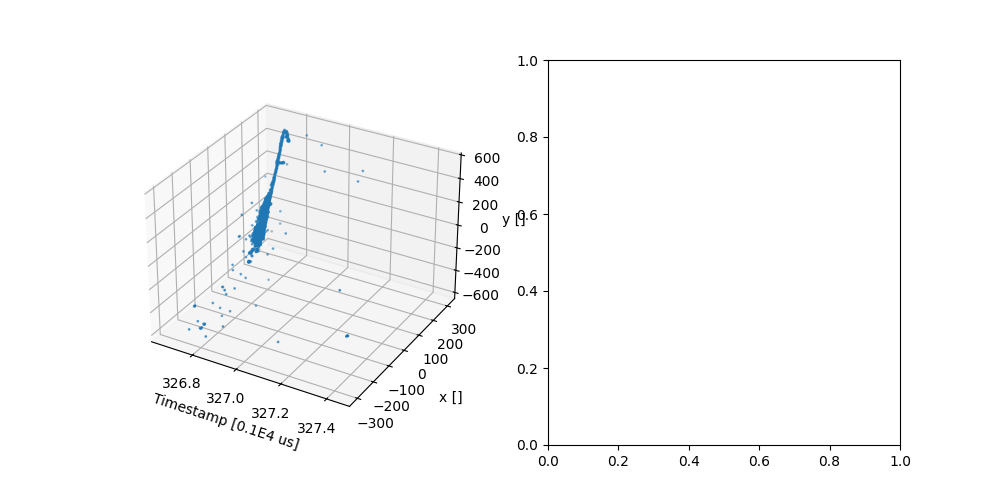

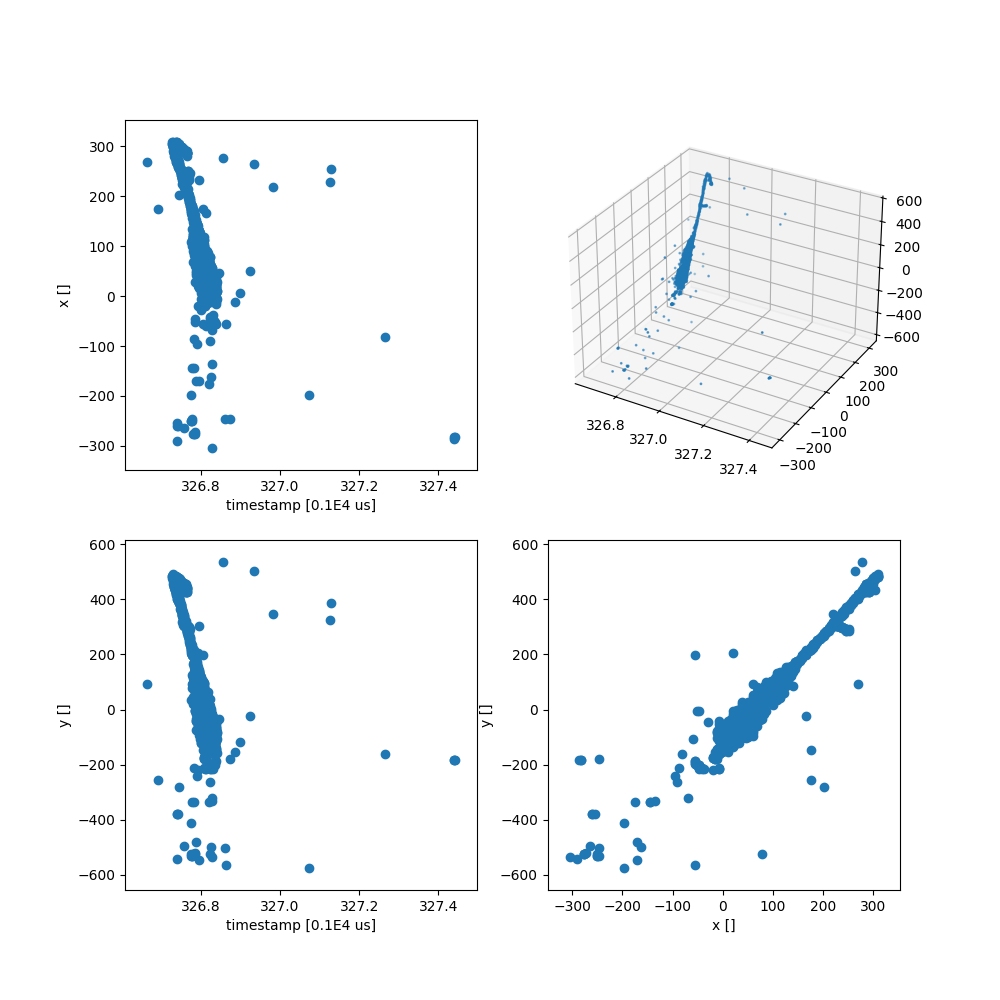

Output()

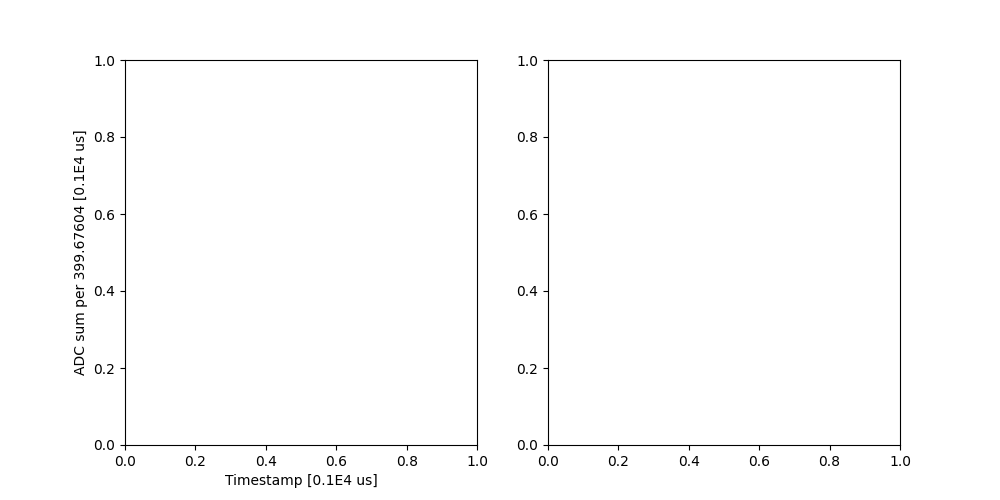

Output()

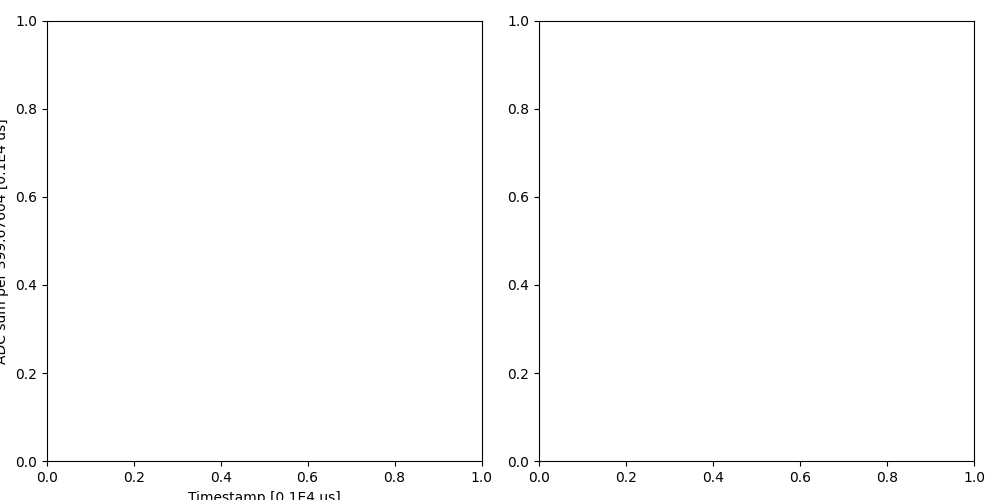

In [78]:
interactive_plot_adc(2, 4, 500)
# 6, 40, 20

55253  data packets between syncs
8  candidate events
14651  hits in event


Button(description='Reset picked points', layout=Layout(width='500px'), style=ButtonStyle())

Button(description='Update ADC sum in range', layout=Layout(width='500px'), style=ButtonStyle())

Output()

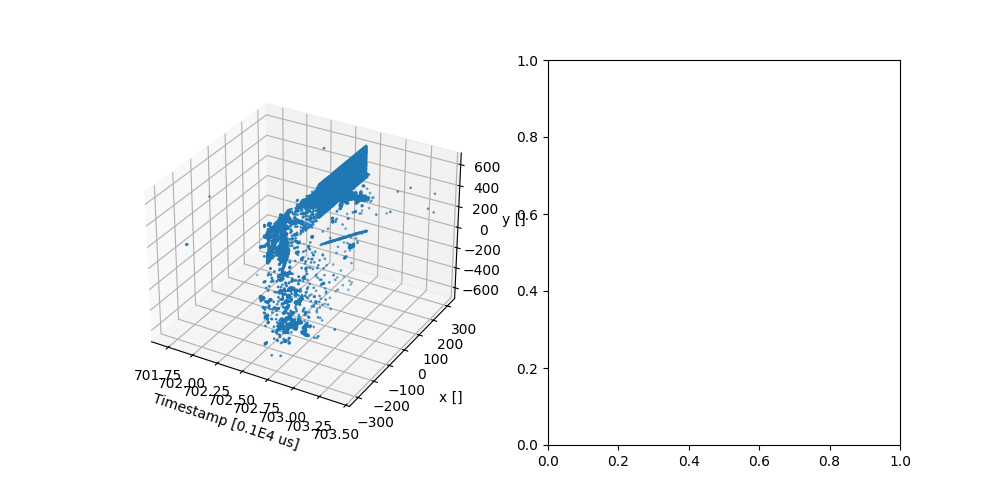

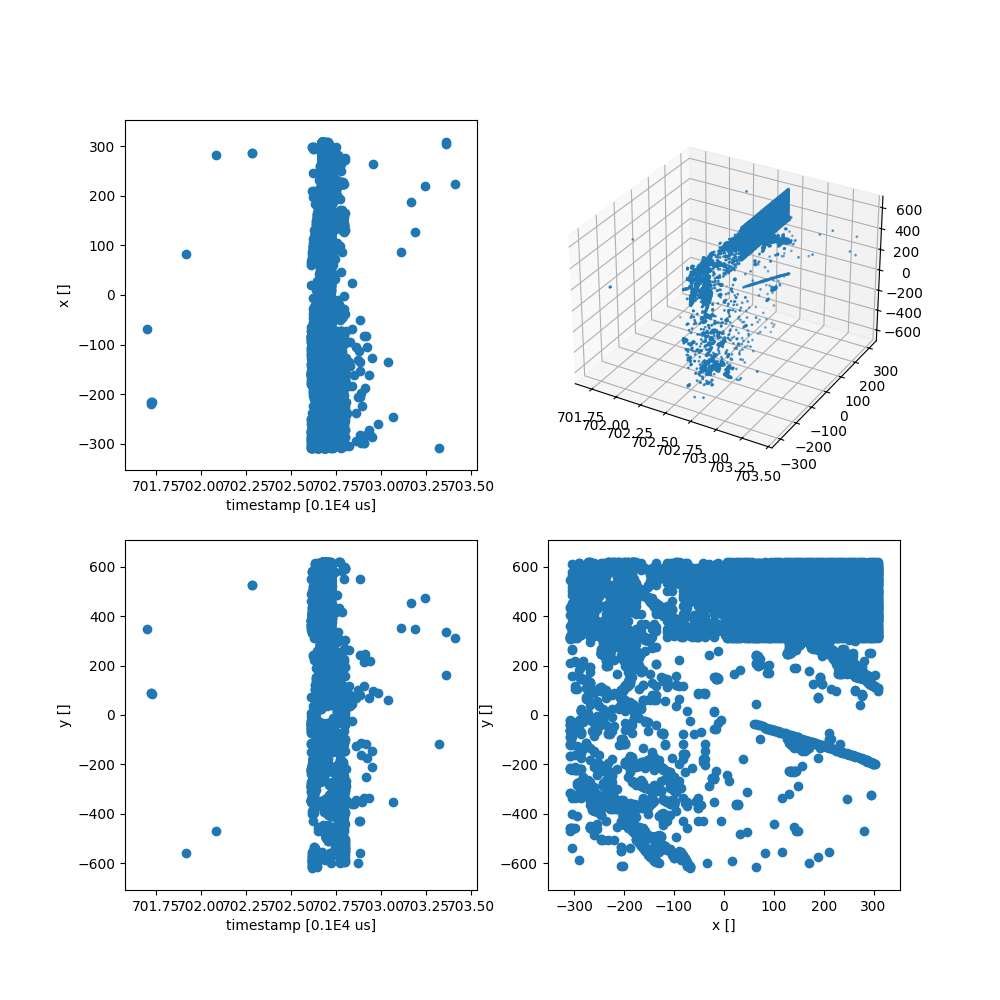

Output()

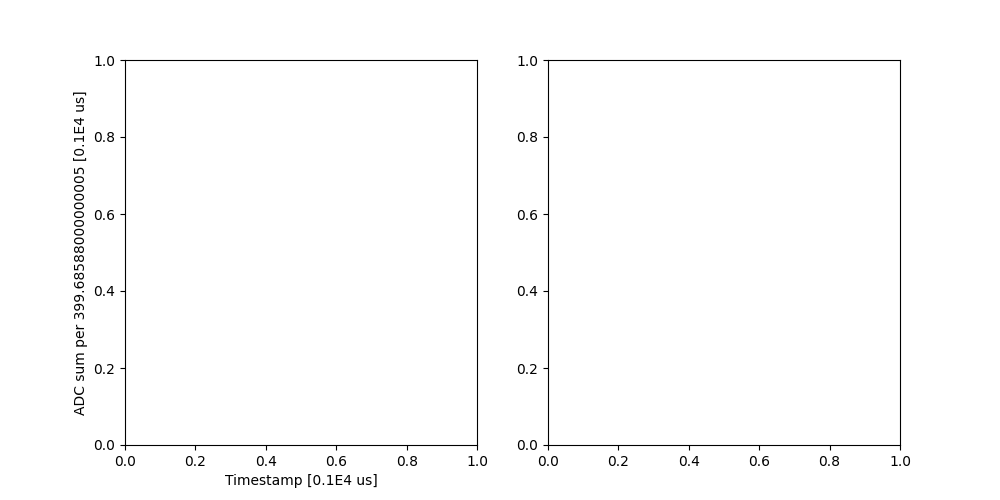

Output()

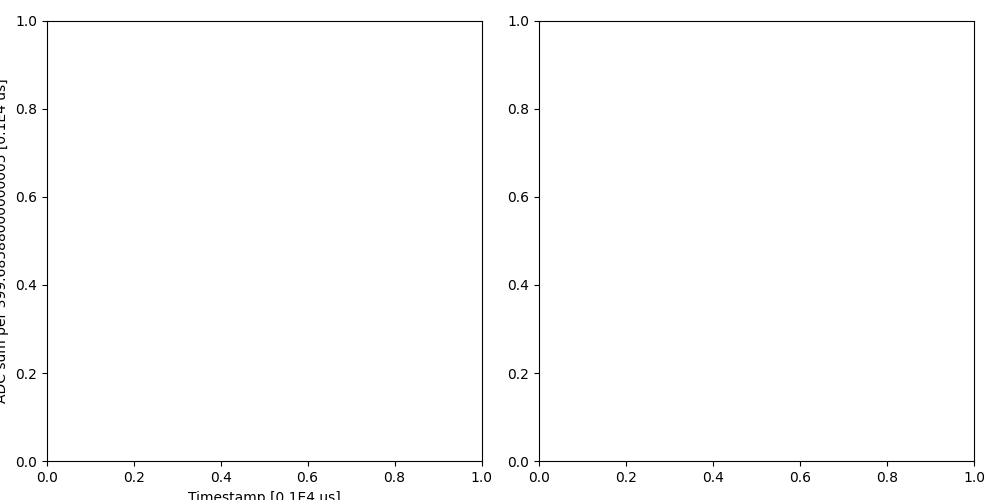

In [81]:
interactive_plot_adc(121, 6, 500)

In [90]:
def check_tile(sync_group, counter, threshold, x0, x1, y0, y1, t0, t1):
    """plot ADC sum given (xpos, ypos).
    sync_group: integer, packets within the same SYNC
    counter: integer, the bin to plot, containing larger number of packets than threshold
    threshold: minimum of threshold within a time duration
    """

    
    plt.close('all')

    helper = geohelper()

    mg = message_groups[sync_group]
    data_mask=((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp 
    data_packets=mg[data_mask]
    print(len(data_packets),' data packets between syncs')

    # histogram the timestamp packet field
    # roughly 200 microseconds binning assuming ticks up to value 1e7 in datastream between syncs
    counts, xbins = np.histogram(data_packets['timestamp'], bins=500)
    bin_width=xbins[1]-xbins[0]

    physics_bins=[] # save to list bin index for bins exceeding threshold
    for i in range(len(counts)):
        if counts[i]>threshold: physics_bins.append(i)

    print(len(physics_bins),' candidate events')

    if len(physics_bins)==1: return # due to correlated-sync noise, we will always have significant pickup near 0 timestamp

    event_mask = (data_packets['timestamp']>=physics_bins[counter]*bin_width)&(data_packets['timestamp']<physics_bins[counter]*bin_width+bin_width) # filter packets on histgrammed bin of interest
    hits = data_packets[event_mask]
    io_channel = hits['io_channel']
    tile_id = np.array([helper.io_channel_to_tile(ioc) for ioc in io_channel])
    chip_id = hits['chip_id']
    channel_id = hits['channel_id']
    timestamp = hits['timestamp']/1e4 # ms
    dataword = hits['dataword'] # ADC value
    # correlate hardware ID to geometry information to find (x,y) position of hits
    xys = np.fromiter((helper.find_xy(tile, chip, channel) for tile, chip, channel in zip(tile_id, chip_id, channel_id)),
                      dtype=np.dtype((np.float64, 2)))
    x = xys[:,0]
    y = xys[:,1]

    print(len(dataword),' hits in event')

    
    tmin0 = physics_bins[counter]*bin_width / 1E4  #ms
    tmax0 = (physics_bins[counter]*bin_width+bin_width) / 1E4  # ms

    xyzmask = (x > x0) & (x < x1) & (y > y0) & (y < y1) & (timestamp > t0) & (timestamp < t1)

    df = pd.DataFrame(tile_id[xyzmask], columns=['tile_id'])
    print(df.value_counts())
    


In [91]:
check_tile(121, 6, 500, -300, 300, -600, 600, 701, 703)

55253  data packets between syncs
8  candidate events
14651  hits in event
tile_id
2          8079
1          2737
8           820
4           709
3           659
5           430
6           270
7            22
Name: count, dtype: int64


In [92]:
check_tile(121, 6, 500, -300, 300, 150, 600, 701, 703)

55253  data packets between syncs
8  candidate events
14651  hits in event
tile_id
2          8079
1          2737
4           666
3           447
Name: count, dtype: int64


50409  data packets between syncs
9  candidate events
9630  hits in event


Button(description='Reset picked points', layout=Layout(width='500px'), style=ButtonStyle())

Button(description='Update ADC sum in range', layout=Layout(width='500px'), style=ButtonStyle())

Output()

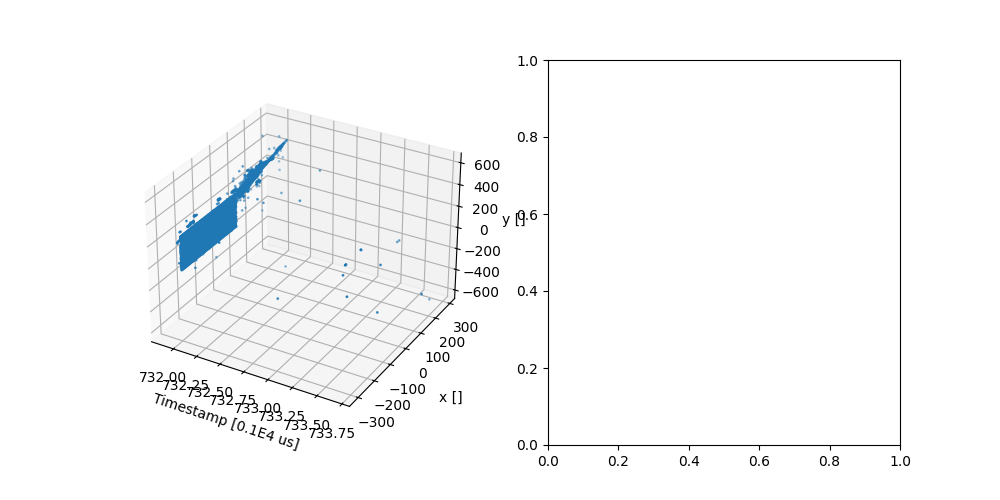

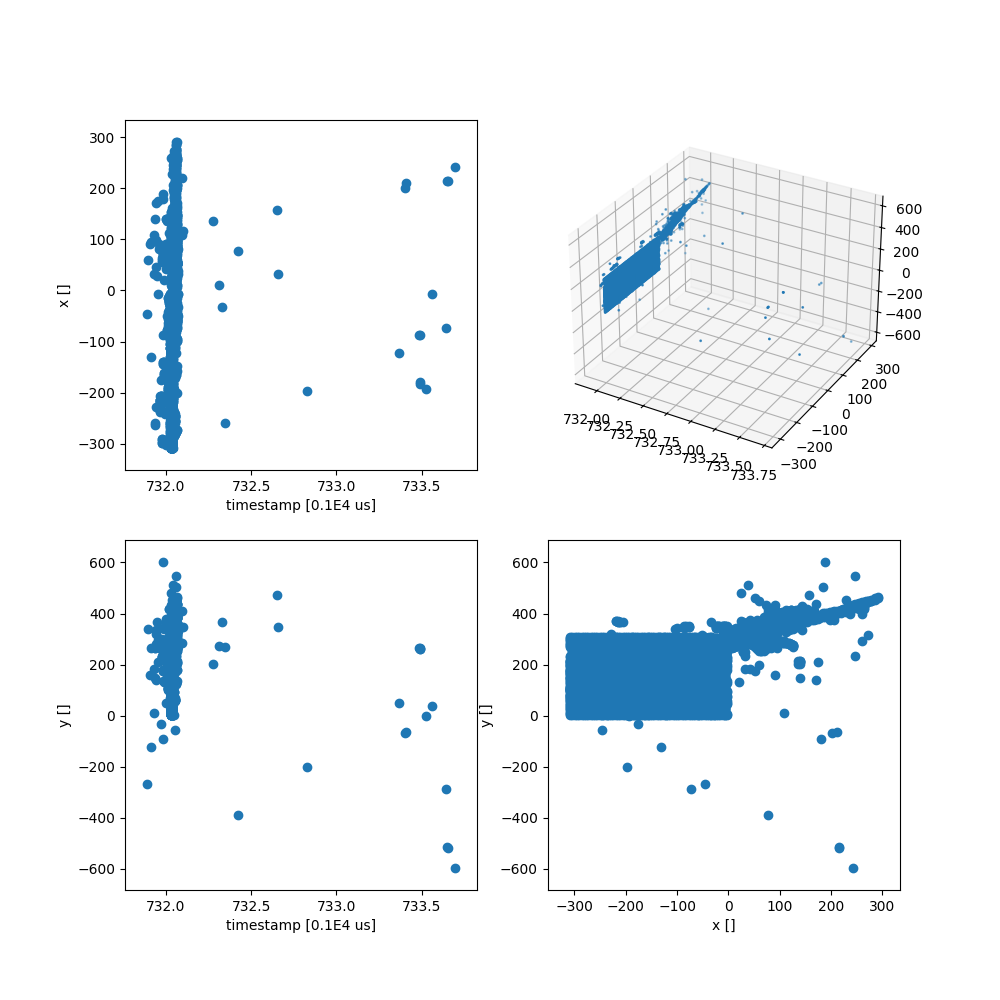

Output()

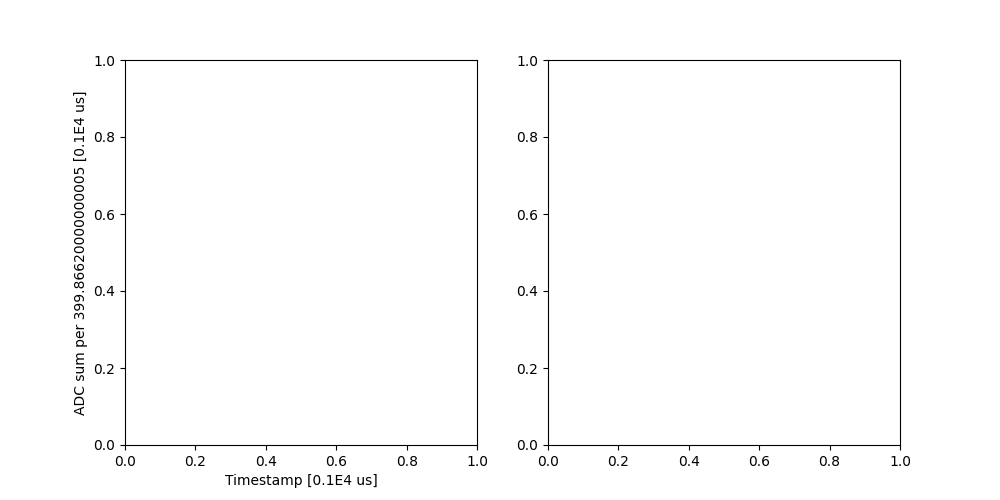

Output()

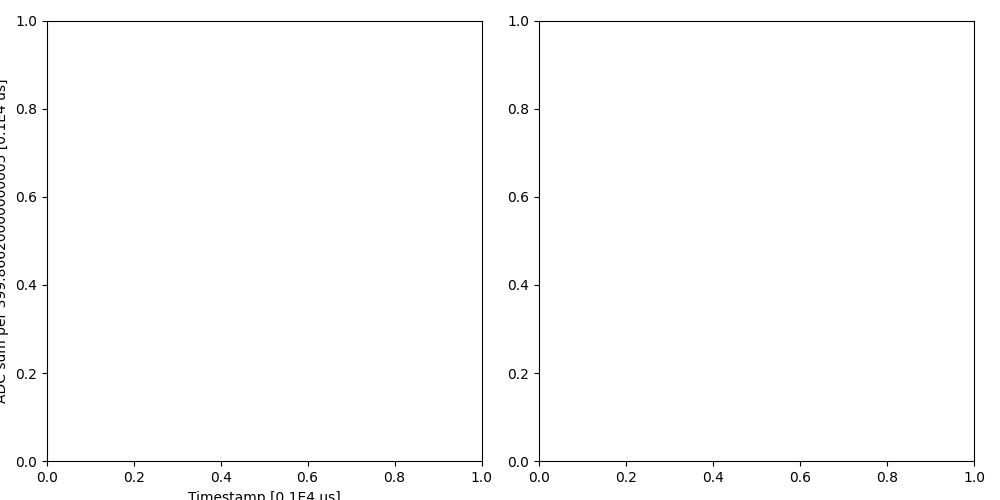

In [93]:
interactive_plot_adc(11, 6, 500)

In [95]:
check_tile(11, 6, 500, -300, 0, 0, 150, 731, 733)

50409  data packets between syncs
9  candidate events
9630  hits in event
tile_id
3          3800
Name: count, dtype: int64
